In [109]:
import keras.optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#导入必要的库

In [110]:
#读取降雨径流数据
df = pd.read_csv("/Users/datou/PycharmProjects/model/HengyangSta/HY_data/衡阳站降雨径流.csv", parse_dates=["Date"])
df_copy = df
df.reset_index(drop=True)
df = df.set_index('Date')
df

,Q,P
Date,,
1985-01-01,385,1.218001
1985-01-02,353,1.418061
1985-01-03,350,1.519668
1985-01-04,375,1.140323
1985-01-05,360,2.144906
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [111]:
n_past=15

In [112]:
#划分数据
test_split = round(len(df) * 0.30)
df_for_training = df[:-test_split]
df_for_testing = df[-(test_split+n_past):]
df_for_testing

,Q,P
Date,,
1996-11-10,393,0.631212
1996-11-11,384,2.396213
1996-11-12,456,3.359430
1996-11-13,471,1.110440
1996-11-14,395,0.492048
...,...,...
2001-12-27,766,0.000000
2001-12-28,653,0.000000
2001-12-29,536,0.000000


In [113]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled = pd.DataFrame(df_for_training_scaled, columns=df_for_training.columns)
df_for_testing_scaled = pd.DataFrame(df_for_testing_scaled, columns=df_for_training.columns)
df_for_training_scaled

,Q,P
0,0.015259,0.020511
1,0.013373,0.023880
2,0.013197,0.025591
3,0.014669,0.019203
4,0.013786,0.036120
...,...,...
4341,0.014611,0.000028
4342,0.011135,0.000592
4343,0.010251,0.001169
4344,0.012372,0.001834


In [114]:
#构造训练集测试集 
# 创建数据集，n_past：时间步长
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(np.array(dataset)[i - n_past:i, 0:np.array(dataset).shape[1]])
        dataY.append(np.array(dataset)[i, 0])
    return np.array(dataX), np.array(dataY)

In [115]:
trainX, trainY = createXY(df_for_training_scaled, n_past)
trainX.shape, trainY.shape

((4331, 15, 2), (4331,))

In [116]:
testX, testY = createXY(df_for_testing_scaled, n_past)
testX.shape, testY.shape

((1863, 15, 2), (1863,))

In [142]:
# BP神经网络输入是二维数据！！！一定要将处理过后的三维数据转为二维数据！！！
trainX = trainX.reshape(len(trainX), n_past * 2)

In [118]:
testX = testX.reshape(len(testX), n_past * 2)

In [119]:
#建立bp模型 训练 
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam


def build_model():
    model = Sequential()  #层次模型
    model.add(Dense(16, input_dim=2*n_past, kernel_initializer='uniform', activation='relu'))  #输入层，Dense表示BP层
    #model.add(Activation('relu'))  #添加激活函数
    model.add(Dense(64, bias_initializer='uniform', activation='sigmoid'))  #中间层
    #model.add(Activation('sigmoid'))  #添加激活函数
    model.add(Dense(1))  #输出层
    learning_rate = 3e-3
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)  #编译模型
    return model

# model=build_model()
# 
# model.fit(trainX, trainY, epochs =50, batch_size = 16) #训练模型nb_epoch=50次

In [120]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 交叉搜索，寻求模型最佳参数，并输出最佳模型
parameters = {'batch_size': [16, 20],
              'epochs': [20, 50]}
"""
verbose参数设置为 2，可以将显示的信息量减小到每轮训练的损失。
可以通过将verbose设置为 1 来关闭所有输出
使用KerasRegressor来包装Keras模型进行网格搜索和交叉验证
"""
grid_model = KerasRegressor(build_fn=build_model, verbose=1)
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters,
                           cv=5)

/var/folders/p_/spnxgg1953n3fzj8z81sv51r0000gn/T/ipykernel_42231/472627789.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1)


In [121]:
"""
训练网络
"""
grid_search = grid_search.fit(trainX, trainY)
# 将最佳模型保存在my_model变量中
model = grid_search.best_estimator_

Epoch 1/20
217/217 [==============================] - 0s 373us/step - loss: 0.0032
Epoch 2/20
217/217 [==============================] - 0s 349us/step - loss: 0.0010
Epoch 3/20
217/217 [==============================] - 0s 339us/step - loss: 9.4072e-04
Epoch 4/20
217/217 [==============================] - 0s 337us/step - loss: 8.4749e-04
Epoch 5/20
217/217 [==============================] - 0s 335us/step - loss: 7.8530e-04
Epoch 6/20
217/217 [==============================] - 0s 333us/step - loss: 7.5948e-04
Epoch 7/20
217/217 [==============================] - 0s 329us/step - loss: 6.5630e-04
Epoch 8/20
217/217 [==============================] - 0s 347us/step - loss: 5.1370e-04
Epoch 9/20
217/217 [==============================] - 0s 341us/step - loss: 4.9253e-04
Epoch 10/20
217/217 [==============================] - 0s 384us/step - loss: 4.8788e-04
Epoch 11/20
217/217 [==============================] - 0s 386us/step - loss: 5.2641e-04
Epoch 12/20
217/217 [============================

In [122]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 20}

In [123]:
"""
在测试集上的预测
"""
y_predict = model.predict(testX)

117/117 [==============================] - 0s 212us/step


In [124]:
train_predict = model.predict(trainX)

271/271 [==============================] - 0s 190us/step


In [125]:
# 逆缩放
prediction_copies_array = np.repeat(y_predict, 2, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_predict), 2)))[:, 0]
pred

array([412.51212, 427.12274, 427.80844, ..., 565.22125, 517.9996 ,
       511.6287 ], dtype=float32)

In [126]:
pred = pd.DataFrame(pred)
pred.columns = ['Qsim']
pred

,Qsim
0,412.512115
1,427.122742
2,427.808441
3,357.890106
4,402.053345
...,...
1858,705.562256
1859,683.908508
1860,565.221252
1861,517.999573


In [127]:
# 同样步骤进行逆变换
original_copies_array = np.repeat(testY, 2, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), 2)))[:, 0]
original = pd.DataFrame(original)
original.columns = ['Qobs']
original

,Qobs
0,391.0
1,383.0
2,292.0
3,316.0
4,309.0
...,...
1858,766.0
1859,653.0
1860,536.0
1861,483.0


In [128]:
# 对测试集输出数据进行逆变换
prediction_copies_array = np.repeat(train_predict, 2, axis=-1)
train_pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(train_predict), 2)))[:, 0]
train_pred.shape

(4331,)

In [129]:
# 对测试数据Y进行逆变换
train_original_copies_array = np.repeat(trainY, 2, axis=-1)
train_original = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(trainY), 2)))[:, 0]
train_original.shape

(4331,)

In [130]:
train_pred = pd.DataFrame(train_pred)
train_pred.columns = ['Qsim']
train_pred

,Qsim
0,535.808289
1,494.263367
2,559.149109
3,556.464966
4,462.319031
...,...
4326,417.075775
4327,429.287842
4328,377.700531
4329,365.455322


In [131]:
train_original = pd.DataFrame(train_original)
train_original.columns = ['Qobs']
train_original

,Qobs
0,479.0
1,542.0
2,557.0
3,476.0
4,464.0
...,...
4326,374.0
4327,315.0
4328,300.0
4329,336.0


In [132]:
df_copy

,Date,Q,P
0,1985-01-01,385,1.218001
1,1985-01-02,353,1.418061
2,1985-01-03,350,1.519668
3,1985-01-04,375,1.140323
4,1985-01-05,360,2.144906
...,...,...,...
6204,2001-12-27,766,0.000000
6205,2001-12-28,653,0.000000
6206,2001-12-29,536,0.000000
6207,2001-12-30,483,0.000000


In [133]:
test_df = df_copy[-test_split :]
test_df

,Date,Q,P
4346,1996-11-25,391,0.067122
4347,1996-11-26,383,0.429786
4348,1996-11-27,292,0.194327
4349,1996-11-28,316,1.199373
4350,1996-11-29,309,0.971816
...,...,...,...
6204,2001-12-27,766,0.000000
6205,2001-12-28,653,0.000000
6206,2001-12-29,536,0.000000
6207,2001-12-30,483,0.000000


In [134]:
train_df = df_copy[n_past:-test_split]
train_df

,Date,Q,P
15,1985-01-16,479,2.189848
16,1985-01-17,542,2.253480
17,1985-01-18,557,0.019066
18,1985-01-19,476,0.030029
19,1985-01-20,464,0.040337
...,...,...,...
4341,1996-11-20,374,0.001667
4342,1996-11-21,315,0.035148
4343,1996-11-22,300,0.069435
4344,1996-11-23,336,0.108885


In [135]:
test_df = test_df.reset_index(drop=True)
test_df = test_df['Date']
test_df

0      1996-11-25
1      1996-11-26
2      1996-11-27
3      1996-11-28
4      1996-11-29
          ...    
1858   2001-12-27
1859   2001-12-28
1860   2001-12-29
1861   2001-12-30
1862   2001-12-31
Name: Date, Length: 1863, dtype: datetime64[ns]

In [136]:
train_df = train_df.reset_index(drop=True)
train_df = train_df['Date']
train_df

0      1985-01-16
1      1985-01-17
2      1985-01-18
3      1985-01-19
4      1985-01-20
          ...    
4326   1996-11-20
4327   1996-11-21
4328   1996-11-22
4329   1996-11-23
4330   1996-11-24
Name: Date, Length: 4331, dtype: datetime64[ns]

In [137]:
test_df_full = pd.concat([test_df, original, pred], axis=1)
test_df_full = test_df_full.reset_index(drop=True)
test_df_full = test_df_full.set_index('Date')
test_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TestBP.csv')
test_df_full.resample("Y").min()

,Qobs,Qsim
Date,,
1996-12-31,292.0,353.314819
1997-12-31,266.0,387.204224
1998-12-31,148.0,275.587952
1999-12-31,103.0,275.587952
2000-12-31,286.0,395.535553
2001-12-31,352.0,396.559937


In [138]:
train_df_full = pd.concat([train_df, train_original, train_pred], axis=1)
train_df_full = train_df_full.reset_index(drop=True)
train_df_full = train_df_full.set_index('Date')
train_df_full.to_csv('/Users/datou/PycharmProjects/model/HengyangSta/HY_data/HY_TrainBP.csv')
train_df_full.resample("Y").min()

,Qobs,Qsim
Date,,
1985-12-31,175.0,312.463226
1986-12-31,142.0,279.775757
1987-12-31,129.0,275.587952
1988-12-31,126.0,280.831512
1989-12-31,128.0,276.760803
1990-12-31,163.0,286.116516
1991-12-31,234.0,342.076538
1992-12-31,181.0,286.684875
1993-12-31,271.0,360.664276


In [139]:
# 计算nash效率系数
from tool import evalIndicator

evalIndicator.eval(test_df_full['Qsim'], test_df_full['Qobs'])

MAE:208.84336236287237
RMSE:375.34816667611466
R2:0.9352532572447898
NSE:0.9352532572447907
RE:-3.117866608796534
Qmaxe:0.04162896681201551
Qmine:1.6756111811665655


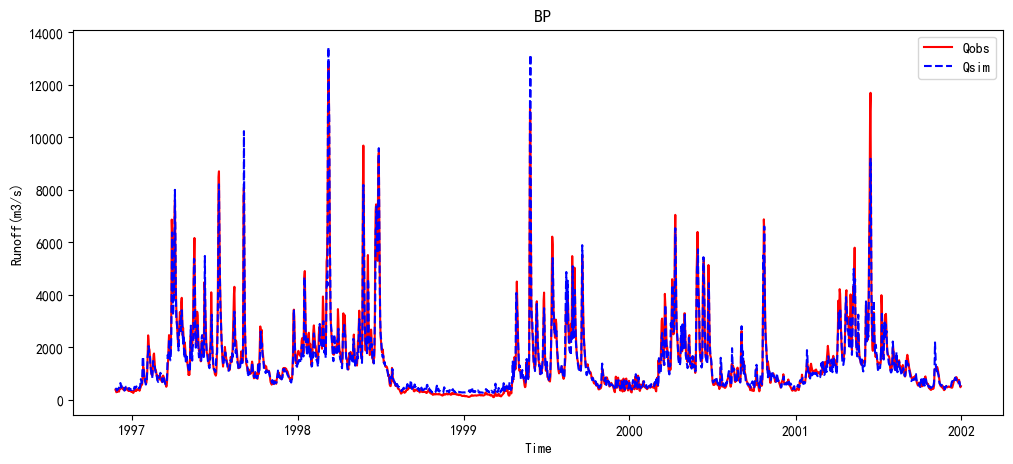

In [140]:
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12, 5))
plt.plot(test_df_full['Qobs'], color='red', label='Qobs')
plt.plot(test_df_full['Qsim'], color='blue', label='Qsim', linestyle="--")
plt.title(' BP')
plt.xlabel('Time')
plt.ylabel('Runoff(m3/s)')
plt.savefig("/Users/datou/PycharmProjects/model/HengyangSta/HY_picture/HY_TestBP.png")
plt.legend()
plt.show()

MAE:175.7433023111453
RMSE:329.4317842602679
R2:0.9402810991480064
NSE:0.9402810991480072
RE:-2.221886014014466
Qmaxe:0.006318073830409356
Qmine:1.1872059655567957


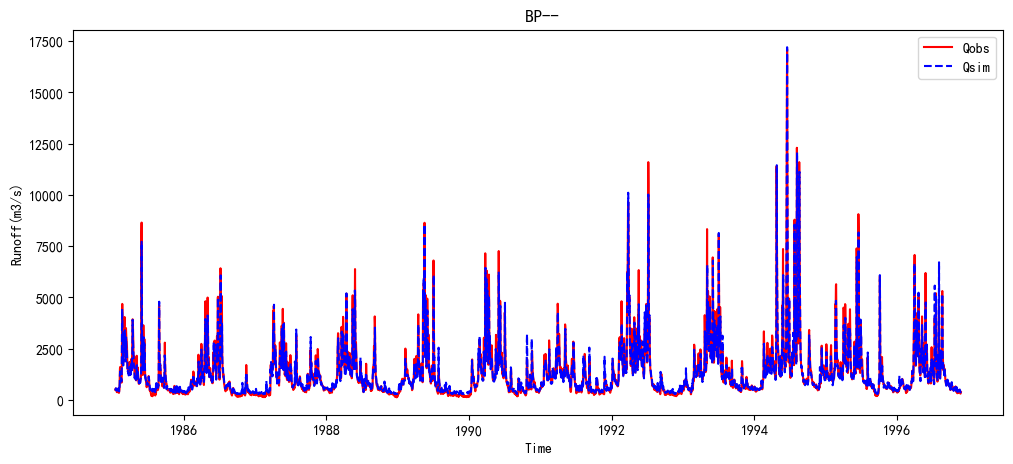

In [141]:
# 计算nash效率系数
evalIndicator.eval(train_df_full['Qsim'], train_df_full['Qobs'])
# 比较预测值和原始值，进行绘图展示
plt.figure(figsize=(12, 5))
plt.plot(train_df_full['Qobs'], color='red', label='Qobs')
plt.plot(train_df_full['Qsim'], color='blue', label='Qsim', linestyle="--")
plt.title(' BP--')
plt.xlabel('Time')
plt.ylabel('Runoff(m3/s)')
plt.savefig("/Users/datou/PycharmProjects/model/HengyangSta/HY_picture/HY_TrainBP.png")
plt.legend()
plt.show()